# Classification task

In [ ]:
# installation of packages
!pip install nltk

In [ ]:
# installation of NLTK data
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

## Data pre-processing

In [1]:
# Loading data
import ast
import pandas as pd

# reading the dataset 
df = pd.read_csv('../data/dataset_filtered_labels.csv')

# getting the list of genres 
genres = set()
for v in df['genres'].values: genres = set(list(genres) + ast.literal_eval(v))
genres = list(genres)

# creating the mappings from genres to id and vice versa
genre2id = {k:v for (v, k) in enumerate(genres)}
id2genre = {k:v for (k, v) in enumerate(genres)}

df.head()

,Unnamed: 0,wiki_id,frbs_id,name,author,date,genres,summary
0,0,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,"['humor', 'realistic fiction', ""children's lit...","Old Major, the old boar on the Manor Farm, cal..."
1,1,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,"['humor', 'science fiction']","Alex, a teenager living in near-future England..."
2,2,986,/m/0ldx,The Plague,Albert Camus,1947,['realistic fiction'],The text of The Plague is divided into five pa...
3,3,2080,/m/0wkt,A Fire Upon the Deep,Vernor Vinge,NaN,"['science fiction', 'fantasy']",The novel posits that space around the Milky W...
4,4,2152,/m/0x5g,All Quiet on the Western Front,Erich Maria Remarque,1929-01-29,"['historical', 'realistic fiction']","The book tells the story of Paul Bäumer, a Ger..."


In [2]:
from sklearn.model_selection import train_test_split
import numpy as np

X = df['summary'].to_numpy() # corpus - predictor variables
Y = np.full((X.shape[0], len(genres)), 0, dtype=int) # genres - target variables

# populating Y

genre_data = df['genres'].to_numpy() # genres assigned to works
for idx in range(len(Y)):
    genre_data[idx] = ast.literal_eval(genre_data[idx])
    for g in genre_data[idx]: Y[idx][genre2id[g]] = 1
        

# splitting dataset in train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=2023)

/home/vera/anaconda3/envs/data_literacy_project/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

# defining tokenizer which performs lemmatization and skips stop or/and non-alphabetic words
class LemmaTokenizer:
    def __init__(self):
        self.stops = set(stopwords.words('english'))
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc) if self.wnl.lemmatize(t) not in self.stops and t.isalpha()]
    
# defining TF-IDF vectorizer
# we put threshold of 1% for term presence in summaries so we can filter out the least common terms
# which can cause the overfitting of the classifier (this choice is backed by Zipf's law)
vectorizer = TfidfVectorizer(tokenizer=LemmaTokenizer(), min_df=0.01)

In [4]:
X_train = vectorizer.fit_transform(X_train) # learning normalized TF-IDF weights
X_test = vectorizer.transform(X_test) # calculating TF-IDF weights


print(X_train.shape, X_test.shape)
print(Y_train.shape, Y_test.shape)

(8554, 2885) (2852, 2885)
(8554, 15) (2852, 15)


## Classifiers

In [114]:
def compute_metrics(Y_test, predictions, target_names):
    
    from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, \
    hamming_loss, classification_report, confusion_matrix, ConfusionMatrixDisplay
    
    import matplotlib.pyplot as plt
    from datetime import datetime
    
    start = datetime.now()

    #______________________________CONFUSTION MATRICES______________________________________________
    
    #print(multilabel_confusion_matrix(y_true = Y_test, y_pred = predictions), labels = target_names)
    f, axes = plt.subplots(3, 5, figsize=(25, 15))
    axes = axes.ravel()
    for i in range(Y_test.shape[1]):
        disp = ConfusionMatrixDisplay(confusion_matrix(Y_test[:, i],
                                                       predictions[:, i]),
                                      display_labels=["yes","no"])
        disp.plot(ax=axes[i], values_format='.4g')
        disp.ax_.set_title(f'{target_names[i]}')
        if i<10:
            disp.ax_.set_xlabel('')
        if i%5!=0:
            disp.ax_.set_ylabel('')
        disp.im_.colorbar.remove()

    plt.subplots_adjust(wspace=0.13, hspace=0.1)
    f.colorbar(disp.im_, ax=axes)
    plt.show()
    
    
    #______________________________ACCURACY AND HAMMING LOSS______________________________________________
    print("Accuracy :",accuracy_score(Y_test, predictions))
    print("Hamming loss ",metrics.hamming_loss(Y_test,predictions))
    
    #______________________________MICRO______________________________________________
    precision = precision_score(Y_test, predictions, average='micro')
    recall = recall_score(Y_test, predictions, average='micro')
    f1 = f1_score(Y_test, predictions, average='micro')

    print("\nMicro-average quality numbers")
    print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

    #______________________________MACRO______________________________________________
    precision = precision_score(Y_test, predictions, average='macro')
    recall = recall_score(Y_test, predictions, average='macro')
    f1 = f1_score(Y_test, predictions, average='macro')

    print("\nMacro-average quality numbers")
    print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
    
    #______________________________SAMPLES______________________________________________
    print("\nSample-average quality numbers")
    print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
    
    precision = precision_score(Y_test, predictions, average='samples')
    recall = recall_score(Y_test, predictions, average='samples')
    f1 = f1_score(Y_test, predictions, average='samples')

    #______________________________CLASSIFICATION REPORT______________________________________________
    print("\nClassification Report")
    print (classification_report(y_true = Y_test, y_pred = predictions, target_names = target_names))
    print("Time taken to run this cell :", datetime.now() - start)

### Multinomial Naive Bayes

In [ ]:
from sklearn.naive_bayes import ComplementNB
from sklearn.multiclass import OneVsRestClassifier

# defining the model and fitting
base_twcnb = ComplementNB()
clf = OneVsRestClassifier(base_twcnb)
clf.fit(X_train, Y_train)

clf.score(X_test, Y_test)

### Random forest classifier
Inherently supports mulitilabel classification

In [76]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from datetime import datetime
from scipy.stats import randint

In [77]:
"""
# Hyperparameter tuning using GridSearchCV
gs_start = datetime.now() 

param_grid = { 
    'n_estimators': [5, 100],
    'max_depth' : [100,200, 250],
    'bootstrap' : [True, False],
    'class_weight': ['balanced', None],
    'min_samples_split' : [2,5]
}

rf = RandomForestClassifier(n_jobs = -1)

gs_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='f1_micro')
gs_rf.fit(X_train, Y_train)

print("Time taken to perform grid search hyperparameter tuning: ",datetime.now()-gs_start)
print("Best estimator: ",gs_rf.best_estimator_)
print("Best Cross Validation Score: ",gs_rf.best_score_)
"""

/home/vera/anaconda3/envs/data_literacy_project/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/vera/anaconda3/envs/data_literacy_project/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/vera/anaconda3/envs/data_literacy_project/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/vera/anaconda3/envs/data_literacy_project/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 a

KeyboardInterrupt: 

In [78]:
# Hyperparameter tuning using RandomizedSearchCV to speed up the computations

st=datetime.now() 

rs_space = {'max_depth':list(np.arange(10, 250, step=10)),
          'n_estimators':np.arange(2, 100, step=10),
          'max_features':randint(1,5),
          'criterion':['gini','entropy'],
          'min_samples_leaf':randint(1,4),
          'min_samples_split':np.arange(2, 10, step=2)}

from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestClassifier(n_jobs = -1)
rsearcg_rf = RandomizedSearchCV(rf, rs_space, n_iter=50, scoring='f1_micro', n_jobs=-1, cv=5)
rsearcg_rf.fit(X_train,Y_train)

print("Time taken to perform hyperparameter tuning: ",datetime.now()-st)
print("Best estimator: ",rsearcg_rf.best_estimator_)
print("Best Cross Validation Score: ",rsearcg_rf.best_score_)


/home/vera/anaconda3/envs/data_literacy_project/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/vera/anaconda3/envs/data_literacy_project/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/vera/anaconda3/envs/data_literacy_project/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/vera/anaconda3/envs/data_literacy_project/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 a

Time taken to perform hyperparameter tuning:  0:02:09.297151
Best estimator:  RandomForestClassifier(criterion='entropy', max_depth=200, max_features=4,
                       min_samples_leaf=2, n_estimators=2, n_jobs=-1)
Best Cross Validation Score:  0.1402958573874759


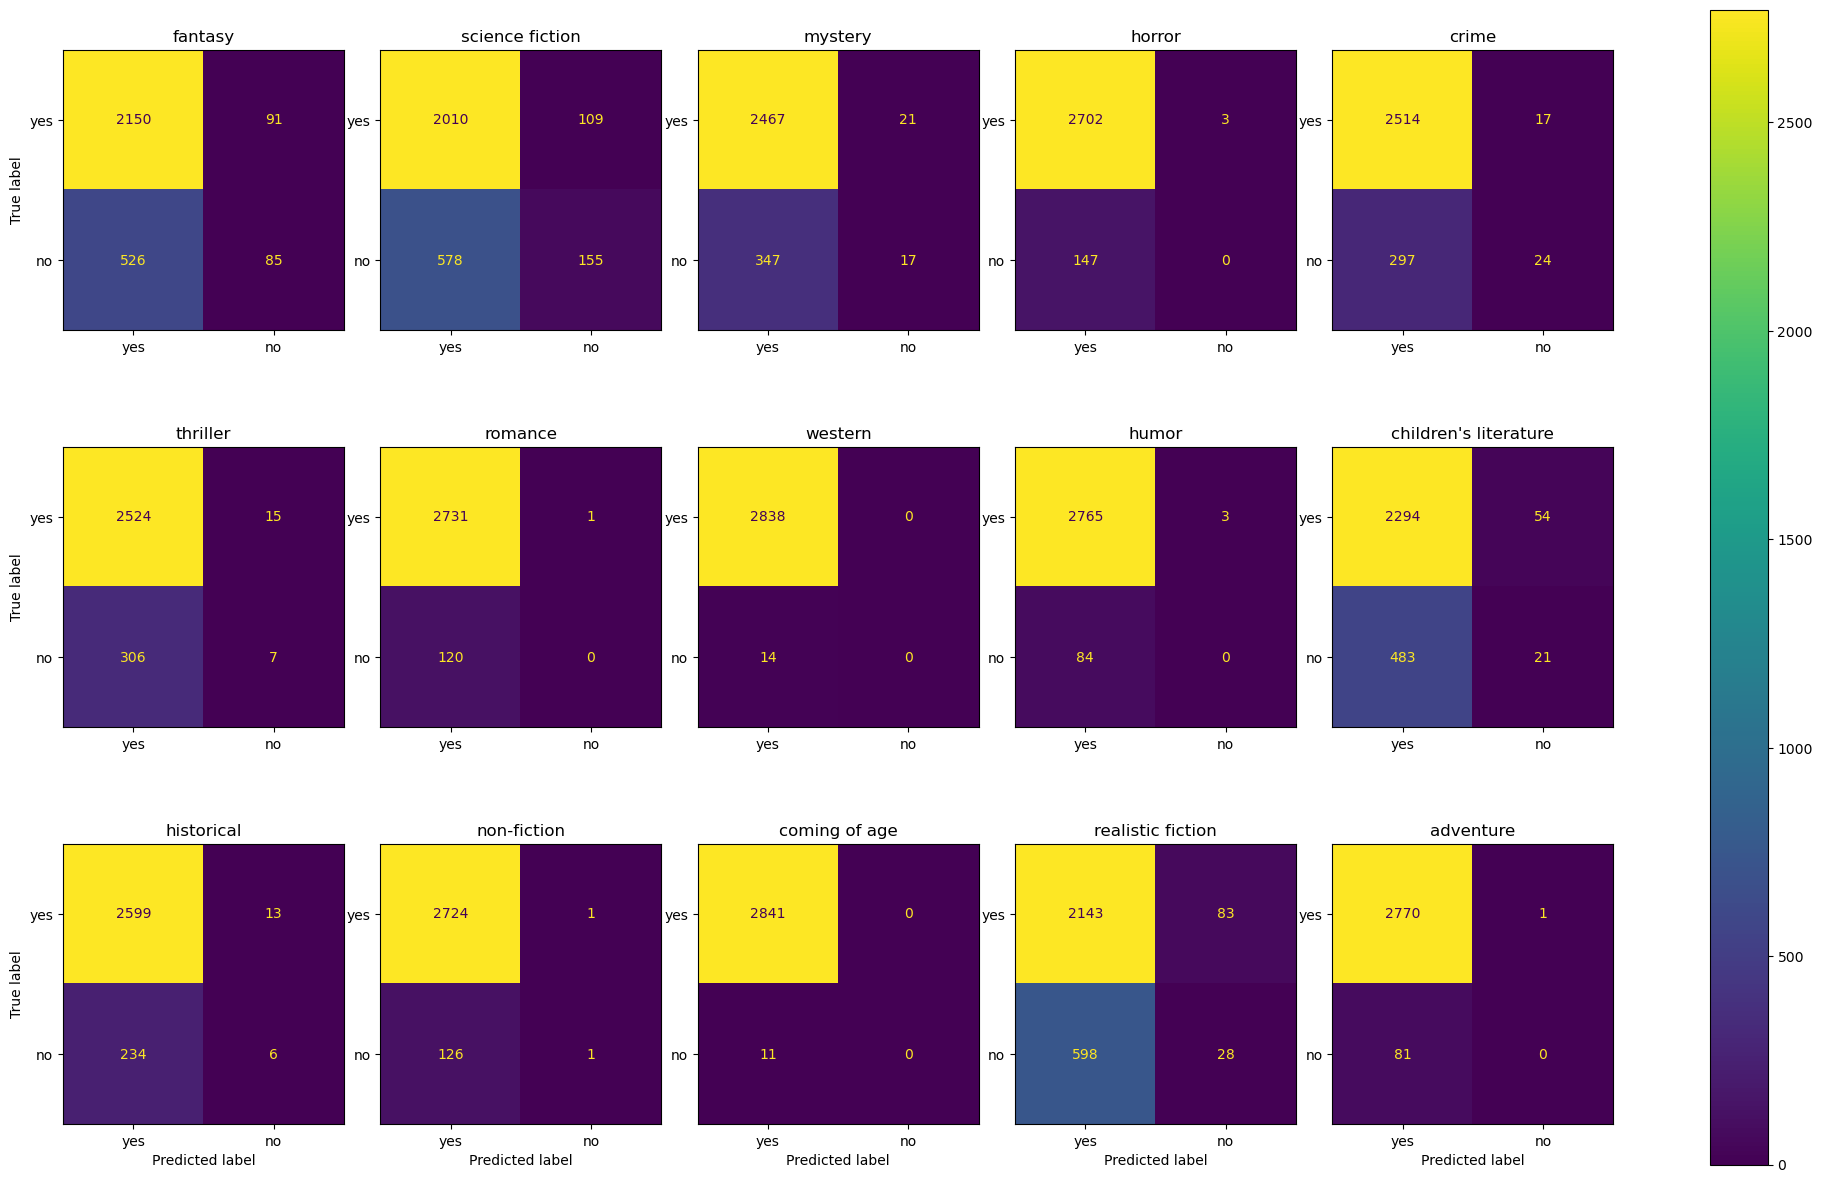

Accuracy : 0.05364656381486676
Hamming loss  0.10201028517999065

Micro-average quality numbers
Precision: 0.4550, Recall: 0.0801, F1-measure: 0.1362

Macro-average quality numbers
Precision: 0.2513, Recall: 0.0409, F1-measure: 0.0664

Sample-average quality numbers
Precision: 0.2513, Recall: 0.0409, F1-measure: 0.0664

Classification Report
                       precision    recall  f1-score   support

              fantasy       0.48      0.14      0.22       611
      science fiction       0.59      0.21      0.31       733
              mystery       0.45      0.05      0.08       364
               horror       0.00      0.00      0.00       147
                crime       0.59      0.07      0.13       321
             thriller       0.32      0.02      0.04       313
              romance       0.00      0.00      0.00       120
              western       0.00      0.00      0.00        14
                humor       0.00      0.00      0.00        84
children's literature    

/home/vera/anaconda3/envs/data_literacy_project/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vera/anaconda3/envs/data_literacy_project/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vera/anaconda3/envs/data_literacy_project/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg

In [115]:
best_model = rsearcg_rf.best_estimator_
best_model.fit(X_train, Y_train)
predictions = best_model.predict(X_test)

compute_metrics(Y_test, predictions, genres)

### XGBoost

In [38]:
import xgboost as xgb
import numpy as np
"""
# experimantal version supports multilabel classification
clf = xgb.XGBClassifier(max_depth = 5, learning_rate = 0.5, gamma = 0.1, seed = 2023, n_jobs = -1, 
                        n_estimators = 100)
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
print(accuracy_score(Y_test,Y_pred))

from sklearn.metrics import f1_score
print(f1_score(Y_test, Y_pred, average=None))
"""

0.255960729312763


In [8]:
# Hyperparamer tuning using GridSearchCV

import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier


param_grid = {
             'estimator__max_depth':[4,5,6],
             #'min_child_weight':[1,2],
             'estimator__learning_rate':[0.05, 0.1, 0.5],
             'estimator__gamma':[i/10.0 for i in range(0,5)],
             #'subsample':[0.5, 0.7],
             #'colsample_bytree':[0.5, 0.7]
             }

model = xgb.XGBClassifier(objective = 'binary:logistic', 
                         n_estimators = 200,            # set initial relatively high number of boosting rounds,
                                                        # and opmtimize it later using XGBoost's cv method
                         seed = 2023,  
                         use_label_encoder = False,
                         num_class=2,
                          n_jobs = -1
                         ) 



one_vs_rest_xgboost = OneVsRestClassifier(xgb.XGBClassifier(n_jobs=-1))

model_tunning = GridSearchCV(one_vs_rest_xgboost, param_grid=param_grid,
                             scoring ='f1_samples')

model_tunning.fit(X_train, Y_train)
print(model_tunning.best_score_)
print(model_tunning.best_params_)
Y_pred_xgboost = model_tunning.predict(X_test)

from sklearn.metrics import f1_score
f1_score(Y_test, Y_pred_xgboost, average=None)

/home/vera/anaconda3/envs/data_literacy_project/lib/python3.10/site-packages/xgboost/sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


0.4054301234611303
{'estimator__gamma': 0.1, 'estimator__learning_rate': 0.5, 'estimator__max_depth': 5}


array([0.62298196, 0.71023622, 0.47232472, 0.32      , 0.54678899,
       0.29176471, 0.11594203, 0.        , 0.02247191, 0.4486692 ,
       0.38438438, 0.41142857, 0.        , 0.35750766, 0.11363636])

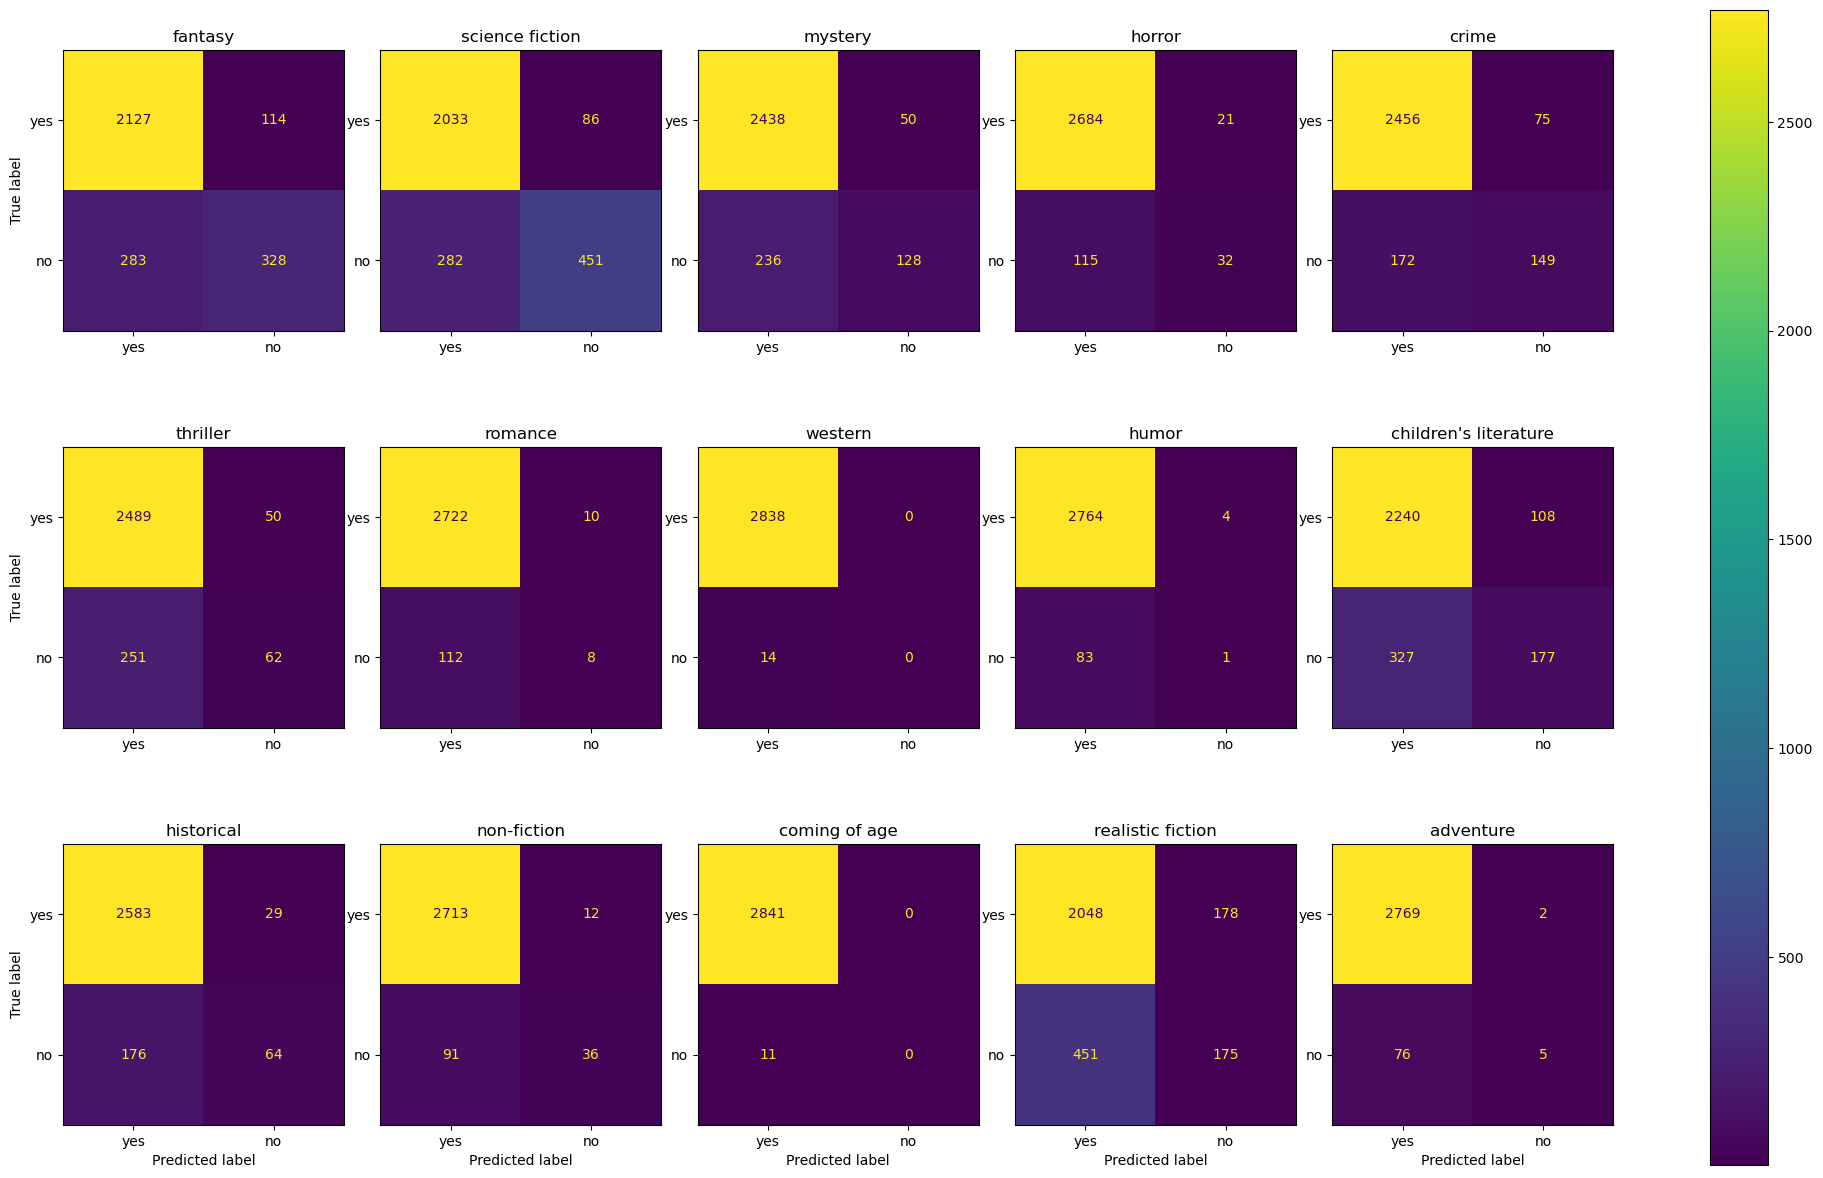

Accuracy : 0.2664796633941094
Hamming loss  0.07992052360916316

Micro-average quality numbers
Precision: 0.6862, Recall: 0.3762, F1-measure: 0.4859

Macro-average quality numbers
Precision: 0.5358, Recall: 0.2470, F1-measure: 0.3212

Sample-average quality numbers
Precision: 0.5358, Recall: 0.2470, F1-measure: 0.3212

Classification Report
                       precision    recall  f1-score   support

              fantasy       0.74      0.54      0.62       611
      science fiction       0.84      0.62      0.71       733
              mystery       0.72      0.35      0.47       364
               horror       0.60      0.22      0.32       147
                crime       0.67      0.46      0.55       321
             thriller       0.55      0.20      0.29       313
              romance       0.44      0.07      0.12       120
              western       0.00      0.00      0.00        14
                humor       0.20      0.01      0.02        84
children's literature     

/home/vera/anaconda3/envs/data_literacy_project/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vera/anaconda3/envs/data_literacy_project/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vera/anaconda3/envs/data_literacy_project/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg

In [118]:
gs_xgboost = model_tunning.best_estimator_
gs_xgboost.fit(X_train, Y_train)
predictions = gs_xgboost.predict(X_test)

compute_metrics(Y_test, predictions, genres)